## Pseudo Labeling

In [833]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import imgaug as ia
import imgaug.augmenters as iaa

import torch
import torchvision

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


DIR_INPUT = './data'
DIR_TRAIN = f'{DIR_INPUT}/train'

In [834]:
train_csv = pd.read_csv(os.path.join(DIR_INPUT, "post_train.csv") ,index_col=0)

In [835]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

In [867]:
class WheatTestDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, mode="train"):
        super().__init__()
        self.image_ids = df["image_id"].unique()
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode
        
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        print("image_id", image_id)
        
        
        records = self.df[self.df["image_id"] == image_id]
        if os.path.exists(os.path.join(self.img_dir, image_id+".jpg")):
            img_path = os.path.join(self.img_dir, image_id+".jpg")
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            img = img/255.0
        
        target = dict()        

        if self.mode == "train":
            bboxes = get_all_bboxes(self.df, image_id)

            BBoxes = []
            for [x, y, w, h] in bboxes:
                BBoxes.append(BoundingBox(x1=x, x2=x+w, y1=y, y2=y+h))
                bbs = BoundingBoxesOnImage(BBoxes, shape=img.shape)

            # Apply augmentations
            if self.transforms:
                image_aug, bbs_aug = self.transforms(image=img, bounding_boxes=bbs)

            boxes = torch.as_tensor([box.coords.reshape(4) for box in bbs_aug.bounding_boxes], dtype=torch.float32)

            boxes[:, 0] = boxes[:, 0]/image_aug.shape[1]
            boxes[:, 1] = boxes[:, 1]/image_aug.shape[0]
            boxes[:, 2] = boxes[:, 2]/image_aug.shape[1]
            boxes[:, 3] = boxes[:, 3]/image_aug.shape[0]
            
            target["boxes"] = boxes
            
            # there is only one class
            labels = torch.ones((records.shape[0],), dtype=torch.int64)
            target['labels'] = labels
        
#             image_before = bbs.draw_on_image(img, size=5)
#             image_after = bbs_aug.draw_on_image(image_aug, size=5, color=[0, 255, 255])
#             fig, axes = plt.subplots(2, 1, figsize=(20, 15))
#             plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8, hspace=0.3, wspace=0.0)
#             axes[0].set_title("image before")
#             axes[0].imshow(image_before)
#             axes[1].set_title("image after augmentation")
#             axes[1].imshow(image_after)
            
            img = transforms.functional.to_tensor(image_aug.copy())
            
            return img, target
        else:
            img = transforms.functional.to_tensor(img).unsqueeze(0)
            return img, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]
    

In [868]:
train_trf = iaa.Sequential([
                            iaa.flip.Fliplr(p=0.8), 
                            iaa.flip.Flipud(p=0.8),
                            iaa.size.Resize({"height": 512, "width": 512}),
                            ])


# val_trf = transforms.Compose([  
#                                 transforms.ToTensor() 
#                             ])

In [869]:
train_ids, valid_ids = train_test_split(train_csv, test_size = 0.05)


train_dataset = WheatTestDataset(train_ids, DIR_TRAIN, train_trf)
valid_dataset = WheatTestDataset(valid_ids, DIR_TRAIN, transforms=None)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_id a0ae5ad8e
image_id 988a60e6e


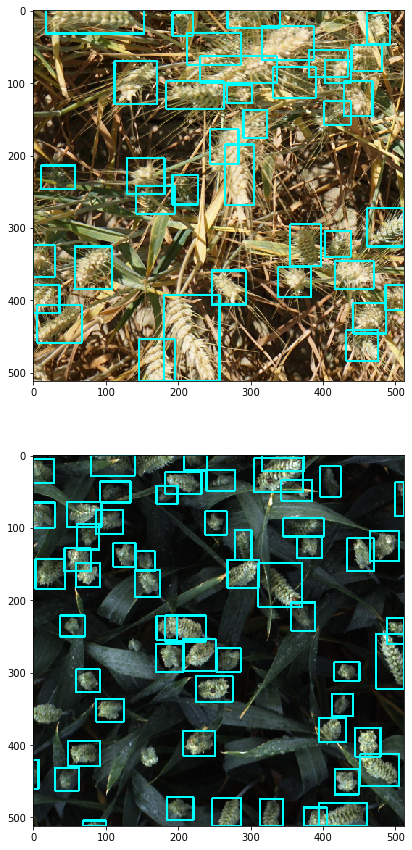

In [870]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

for i in range(2):  
    sample = images[i]
#     img1 = sample.squeeze().permute(1, 2, 0).numpy()
    img1 = sample.squeeze().numpy().transpose(1, 2, 0)
    boxes = targets[i]["boxes"].numpy()
    for box in boxes:
        box = box*img.shape[0]
        img1 = cv2.rectangle(np.ascontiguousarray(img1), (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 255), 2)
    axes[i].imshow(img1)
plt.show()

In [871]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=False)

In [872]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [873]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 2

In [878]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets in train_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

image_id a0ae5ad8e
image_id 988a60e6e


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 11.00 GiB total capacity; 4.22 GiB already allocated; 0 bytes free; 82.56 MiB cached)